# 1. Import Required Packages

In [43]:
import mne
from pathlib import Path 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
import pickle


# sklearn
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier



#matplotlib.use('Qt5Agg')
mne.set_log_level('warning')






# 2. Evaluate Models

epochs: 1014, channels: 32, samples: 513
SVM  Classification score: 0.7940348024319032 (std. 0.058027667086692145)


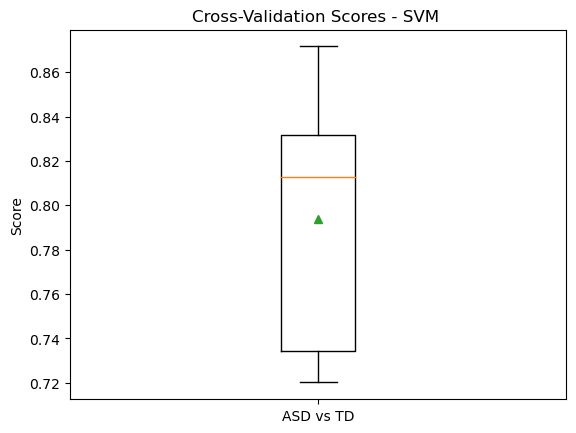

In [45]:


# Get input data. Assumes data is stored in 'out_data' directory
def getInput(file):    
    all_epochs = mne.read_epochs(Path('out_data') / file )
    idx_asd = all_epochs.events[:, 2] == all_epochs.event_id['asd']
    idx_td = all_epochs.events[:, 2] == all_epochs.event_id['td']

    # trails (epochs, channels, samples)
    np_all_epochs = all_epochs.get_data()

    print(f"epochs: {np_all_epochs.shape[0]}, channels: {np_all_epochs.shape[1]}, samples: {np_all_epochs.shape[2]}")
    n_trials = np_all_epochs.shape[0]

    # Labels
    y = np.empty(len(all_epochs.events), dtype=int)  

    # Encode: ASD = 0, TD = 1.
    y[idx_asd] = 0
    y[idx_td] = 1

    return all_epochs, idx_asd, idx_td, np_all_epochs, y

# Get input that includes extracted features
def getProcessedInput(featureCount, fmax, np_all_epochs, all_epochs, featureExtractor):
    X_2d = np.empty([np_all_epochs.shape[0], np_all_epochs.shape[1], featureCount], dtype=float)
    psd_epochs_channels_freqs = all_epochs.compute_psd(fmax=fmax).get_data()  
    for epoch_id, epoch in enumerate(psd_epochs_channels_freqs):
        for channel_id, channel in enumerate(epoch):
            X_2d[epoch_id, channel_id, :] = featureExtractor(channel)

    n_trials = np_all_epochs.shape[0]
    X_2d_reshaped = X_2d.reshape(n_trials, -1)
    return X_2d_reshaped


# Get input that includes extracted features
def getSingleChannelProcessedInput(channel_id, featureCount, fmax, np_all_epochs, all_epochs, featureExtractor):
    X_2d = np.empty([np_all_epochs.shape[0], 1, featureCount], dtype=float)
    psd_epochs_channels_freqs = all_epochs.compute_psd(fmax=fmax).get_data()  
    for epoch_id, epoch in enumerate(psd_epochs_channels_freqs):
        channel = psd_epochs_channels_freqs[epoch_id, channel_id, :]
        X_2d[epoch_id, 0, :] = featureExtractor(channel)

    n_trials = np_all_epochs.shape[0]
    X_2d_reshaped = X_2d.reshape(n_trials, -1)
    return X_2d_reshaped


def visualizeResults(scores, title):
    fig, ax = plt.subplots()
    ax.boxplot(scores,
        showmeans=True, # Green triangle marks the mean.
        whis=(0, 100),  # Whiskers span the entire range of the data.
        labels=['ASD vs TD'])
    ax.set_ylabel('Score')
    ax.set_title(f'Cross-Validation Scores - {title}')
    plt.show()

def testModel(X, y, clf, cv, n_jobs, title, scoring=None):
    scores_full = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring=scoring)
    print(f"{title} Classification score: {np.mean(scores_full)} (std. {np.std(scores_full)})")
    visualizeResults(scores_full, title)


def viewEpochChannelPSD(epoch, channel, matrix):
    # View Epoch channel PSD
    _, ax = plt.subplots()
    _x = np.indices(matrix[epoch, channel, :].shape).squeeze()
    ax.plot(_x , matrix[epoch, channel, :], color='k')
    plt.show()

def runTests(X_2d, y, channel=""):
    # Testing Parameters
    #cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    n_splits = 5
    scoring = 'roc_auc'
    cv = StratifiedKFold(n_splits=n_splits)

    # SVM
    clf = SVC(C=1, kernel='linear')
    testModel(X_2d, y, clf, cv, 1, f"SVM {channel}", scoring)
    saveModel(X_2d, y, clf, "svm.model")


    # Add Random Forest?


    #KNN
    #clf = KNeighborsClassifier(n_neighbors=3)
    #testModel(X_2d, y, clf, cv, 1, f"knn {channel}", scoring)
    #saveModel(X_2d, y, clf, "knn.model")

 
    # LDA
    #clf = LinearDiscriminantAnalysis()
    #testModel(X_2d, y, clf, cv, 1, f"LDA {channel}", scoring)
    #saveModel(X_2d, y, clf, "lda.model")

    # Logistic Regression
    #clf = make_pipeline(StandardScaler(),
    #LogisticRegression(max_iter=500))
    #testModel(X_2d, y, clf, cv, 1, f"Logistic Regression {channel}", scoring)
    #saveModel(X_2d, y, clf, "lr.model")

def saveModel(X, y, clf, filename):
    clf.fit(X, y)
    pickle.dump(clf,open(f"models/{filename}", 'wb'))

def extractFetures(signal):

    delta = np.mean(signal[:4])
    theta = np.mean(signal[4:8])
    alpha = np.mean(signal[8:12])
    beta = np.mean(signal[13:30])
    gamma = np.mean(signal[30:40])
    return [gamma]

def main():
    all_epochs, idx_asd, idx_td, np_all_epochs, y = getInput('train_all_epo.fif')
    X_2d = getProcessedInput(1, 30, np_all_epochs, all_epochs, extractFetures) 
    #runTests(X_2d, y)

    all_epochs.plot()
    #print(X_2d.shape, y.shape)
    #print(X_2d[:, -3:].shape)
    #print(X_2d[0, -3:])
    # Test single channel


    #channel_names = all_epochs.ch_names
    '''
    for i in range(len(all_epochs.ch_names)):
        channel_name = all_epochs.ch_names[i]
        X_2d = getSingleChannelProcessedInput(i, 1, 30, np_all_epochs, all_epochs, extractFetures)
        runTests(X_2d, y, channel_name)
        #print(X_2d)
    '''

    # TODO
    # - Run multiple check for all channels individually using gamma power to see which channel has high accuracy
    # - Show spatially how accuracy differs

    #clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
    #clf = LinearDiscriminantAnalysis()
    #clf = SVC(C=1, kernel='linear')
    #saveModel(X_2d, y, clf, "lr.model")

main()


# 3. Evaluate Model on Unseen Data

In [46]:
def extractFetures(signal):
    delta = np.mean(signal[:4])
    theta = np.mean(signal[4:8])
    alpha = np.mean(signal[8:12])
    beta = np.mean(signal[13:30])
    gamma = np.mean(signal[30:40])
    return [gamma]

def testModel(X_2d, y, model_file, model_name):
    #model_file = "lr.model"
    loaded_model = pickle.load(open(f"models/{model_file}", 'rb'))
    result = loaded_model.score(X_2d, y)
    print(f"{model_name} Classification score: {result}")

def main():
    all_epochs, idx_asd, idx_td, np_all_epochs, y = getInput('test_all_epo.fif')
    X_2d = getProcessedInput(1, 30, np_all_epochs, all_epochs, extractFetures)
    channel_names = all_epochs.ch_names
    #print(X_2d[idx_td].shape, X_2d[idx_asd].shape)
    #all_epochs[0].plot()
    #fp1 = all_epochs[0].pick_channels(["Fp2"])
    #fp1.plot()
    #fp1_data = fp1.get_data().squeeze()
   
    #print("fpz", fp1_data.shape, fp1_data[:3])
    #print(fp1_data[:3], np_all_epochs[0,2,:3])


    #print(all_epochs.shape, np_all_epochs.shape)
    #print(all_epochs)
    testModel(X_2d, y, "svm.model", "SVM")
    #testModel(X_2d, y, "lda.model", "LDA")
    #testModel(X_2d, y, "lr.model", "LR")


    
main()



epochs: 216, channels: 32, samples: 513
SVM Classification score: 0.9398148148148148


In [ ]:
#colors = ["navy", "turquoise"]
#target_names = ["asd", "td"]

#asd_powers = X_2d[idx_asd]
#td_powers = X_2d[idx_td]

#print("shape: ", asd_powers[:, :, 0].shape)



'''
fig, axs = plt.subplots(3, 4)

channelid = 2
for i in range(3):
    for x in range(4):
        axs[i, x].scatter(asd_powers[:, channelid, i], asd_powers[:, channelid, x], alpha=0.5, color="navy", label="ASD")
        axs[i, x].scatter(td_powers[:, channelid, i], td_powers[:, channelid, x], alpha=0.5, color="turquoise", label="TD")
        axs[i, x].legend(loc="best", shadow=False, scatterpoints=1)
        axs[i, x].set_title(f'Axis [{i}, {x}]')
'''

'''
bar_colors = ['tab:red', 'tab:blue']
print("ASD delta avg: ", np.mean(asd_powers[:, :, 0]))
print("TD delta avg: ", np.mean(td_powers[:, :, 0]))
asd_mean_psd = np.mean(asd_powers[:, :, 0])
td_mean_psd =  np.mean(td_powers[:, :, 0])
counts = [asd_mean_psd, td_mean_psd]
        
fig, ax = plt.subplots()
ax.bar(target_names, counts, color=bar_colors)
plt.show()
'''